## One Model

rosshandler: https://pubmed.ncbi.nlm.nih.gov/37982461/ \
nowotschin: https://pubmed.ncbi.nlm.nih.gov/30959515/ \
https://www.nature.com/articles/s41592-021-01336-8 \
https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/harmonization.html \
https://rapids-singlecell.readthedocs.io/en/latest/notebooks/demo_gpu-seuratv3-brain-1M.html 

In [1]:
%%time
# importing our library 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import torch
import os
import scipy
import anndata as ad
import anndata as ad
import rapids_singlecell as rsc
import jax
import psutil
import gc

Global seed set to 0
/home/schroel1/miniconda3/envs/gpu2/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/schroel1/miniconda3/envs/gpu2/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


CPU times: user 5.35 s, sys: 1.47 s, total: 6.83 s
Wall time: 1min 25s


## Memory

In [2]:
## RAM info

# Get information about virtual memory usage
virtual_mem = psutil.virtual_memory()
# Access attributes like total, available, and used memory
total_mem = virtual_mem.total  # Total memory in bytes
available_mem = virtual_mem.available  # Available memory in bytes
used_mem = virtual_mem.used  # Used memory in bytes
# You can also calculate memory usage percentage
percent_used = used_mem / total_mem * 100

# printing it out
print(f"Total Memory: {total_mem / (1024**3)} GB")
print(f"Available Memory: {available_mem / (1024**3)} GB")
print(f"Used Memory: {used_mem / (1024**3)} GB")
print(f"Memory Usage Percentage: {percent_used:.2f}%")

Total Memory: 1007.155345916748 GB
Available Memory: 959.8950576782227 GB
Used Memory: 45.30659103393555 GB
Memory Usage Percentage: 4.50%


## Cuda, torch and jax setup

In [3]:
!nvidia-smi

Tue Nov  5 11:03:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                     On  | 00000000:E3:00.0 Off |                    0 |
|  0%   37C    P0              82W / 300W |    273MiB / 46068MiB |      0%   E. Process |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
print(torch.version.cuda)
use_cuda = torch.cuda.is_available()
use_cuda

11.8


True

In [5]:
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

__CUDNN VERSION: 90100
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA A40
__CUDA Device Total Memory [GB]: 47.622258688


In [6]:
## trading of performance for accuracy, can be set to `medium` `high` `highest`
torch.set_float32_matmul_precision('medium')

In [7]:
!nvcc --version

/bin/bash: nvcc: command not found


In [8]:
print(torch.backends.cudnn.version())

90100


In [9]:
jax.default_backend() ## jax is cpu backend, however I am still able to train with cuda against the gpu

'gpu'

## Data loading

In [10]:
data_path = '/data/hadjantalab/lucas/atlas/data'

In [11]:
file_path = os.path.join(data_path, 'adata.h5ad')
adata = ad.read_h5ad(file_path)
adata

AnnData object with n_obs × n_vars = 535935 × 8342
    obs: 'batch', 'stage', 'sample', 'covariate_composite', 'celltype_nowotschin', 'celltype_rosshandler', 'celltype_pijuansala', 'nowotschin_cluster', 'rosshandler_somite_count', 'rosshandler_anatomy', 'rosshandler_phase', 'rosshandler_S_score', 'rosshandler_G2M_score', 'rosshandler_louvain', 'rosshandler_leiden', 'annotation', 'mt-Atp6', 'mt-Atp8', 'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6', 'S_score', 'G2M_score', 'phase'
    var: 'highly_variable'
    uns: 'colormap_annotation', 'colormap_batch', 'colormap_rosshandler', 'colormap_stage', 'log1p', 'symbolmap_batch', 'symbolmap_plotly_batch', 'symbolmap_plotly_stage', 'symbolmap_stage'
    layers: 'log_normalized', 'raw_counts'

In [12]:
# load scvi model
#file_path = os.path.join(data_path, "scvi/atlas")
#model = scvi.model.SCVI.load(file_path, adata)

## Set a list of continuos covariates

In [18]:
obs_continuous_covariates = [
    'mt-Atp6',
    'mt-Atp8',
    'mt-Co1',
    'mt-Co2',
    'mt-Co3',
    'mt-Cytb',
    'mt-Nd1',
    'mt-Nd2',
    'mt-Nd3',
    'mt-Nd4',
    'mt-Nd4l',
    'mt-Nd5',
    'mt-Nd6',
    'S_score',
    'G2M_score',
]

## scVI Model

In [21]:
## hyperparameters inferred from hyperparameter tuning
n_hidden = 256
n_layers = 1
n_latent = 45
lr = 0.0032

In [22]:
%%time
scvi.model.SCVI.setup_anndata(adata, 
                              batch_key="batch", 
                              categorical_covariate_keys = ['sample', 'stage'],
                              continuous_covariate_keys = obs_continuous_covariates
                             )

/home/schroel1/miniconda3/envs/gpu2/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


CPU times: user 87.8 ms, sys: 22.6 ms, total: 110 ms
Wall time: 1.31 s


In [23]:
%%time
model = scvi.model.SCVI(adata, n_hidden=n_hidden, n_layers=n_layers, n_latent=n_latent, gene_likelihood="nb")

CPU times: user 1.08 s, sys: 662 ms, total: 1.74 s
Wall time: 2.65 s


In [24]:
%%time
model.train(plan_kwargs={"lr": lr})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/15:   0%|          | 0/15 [00:00<?, ?it/s]

/home/schroel1/miniconda3/envs/gpu2/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 15/15: 100%|██████████| 15/15 [08:01<00:00, 31.97s/it, loss=2.99e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 15/15: 100%|██████████| 15/15 [08:01<00:00, 32.08s/it, loss=2.99e+03, v_num=1]
CPU times: user 8min 1s, sys: 18.6 s, total: 8min 20s
Wall time: 8min 2s


## Latent, neighbors and leiden

In [27]:
%%time
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

CPU times: user 13.1 s, sys: 1.55 s, total: 14.7 s
Wall time: 12.9 s


In [30]:
%%time
rsc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY, n_neighbors = 60, key_added = 'neighbors_scVI')

CPU times: user 6.5 s, sys: 4.39 s, total: 10.9 s
Wall time: 13 s


In [25]:
#%%time
#rsc.tl.leiden(adata, neighbors_key ='neighbors_scVI', key_added = 'leiden_scVI')

## UMAPs

In [31]:
%%time
rsc.tl.umap(adata, neighbors_key = 'neighbors_scVI', min_dist=0.5, spread = 0.5, n_components = 2, random_state = 66)
adata.obsm['X_umap_scVI'] = adata.obsm['X_umap'].copy()

CPU times: user 3.17 s, sys: 2.36 s, total: 5.53 s
Wall time: 6.63 s


In [114]:
#adata.obsm['X_umap_scVI_BACKUP'] = adata.obsm['X_umap_scVI'].copy()

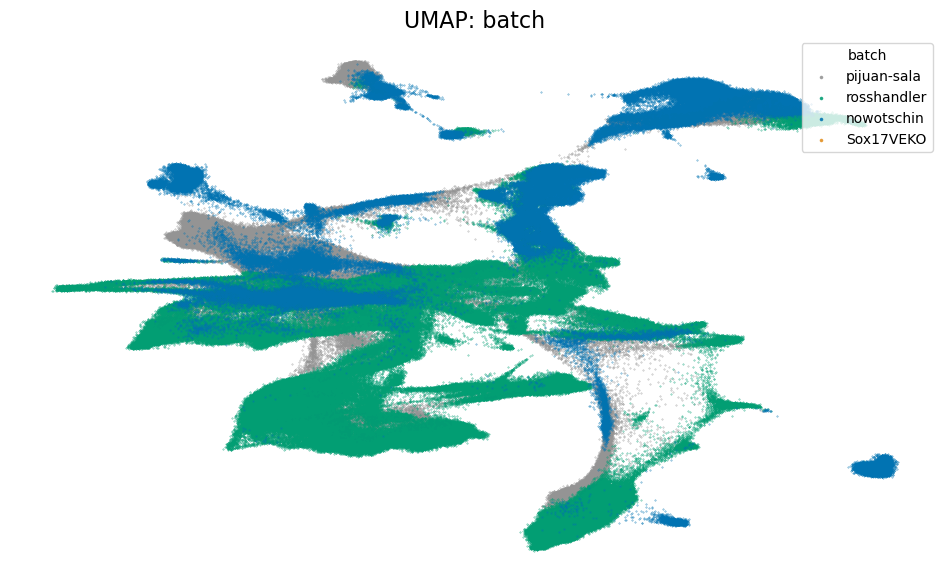

In [32]:

# Define UMAP coordinates
umap_coords = adata.obsm['X_umap_scVI']

# Define the batch variable
voi = 'batch'

# Extract value colors and symbols from adata.uns
colormap = adata.uns[f'colormap_{voi}']

# Set the point size
pointsize = 0.1

# Create a color-mapped and symbol-mapped scatter plot
fig, ax = plt.subplots(figsize=(12, 7))

# Iterate over valuees and plot each with corresponding color and marker
for value, color in colormap.items():
    mask = adata.obs[voi] == value
    ax.scatter(umap_coords[mask, 0], umap_coords[mask, 1], s=pointsize, c=color, label=value, alpha = 0.8)

# Set plot legend and title
ax.legend(title=f'{voi}', loc='upper right', scatterpoints=1, markerscale=5)
ax.set_title(f'UMAP: {voi}', fontsize=16)
ax.axis('off')

# Show the plot
plt.show()


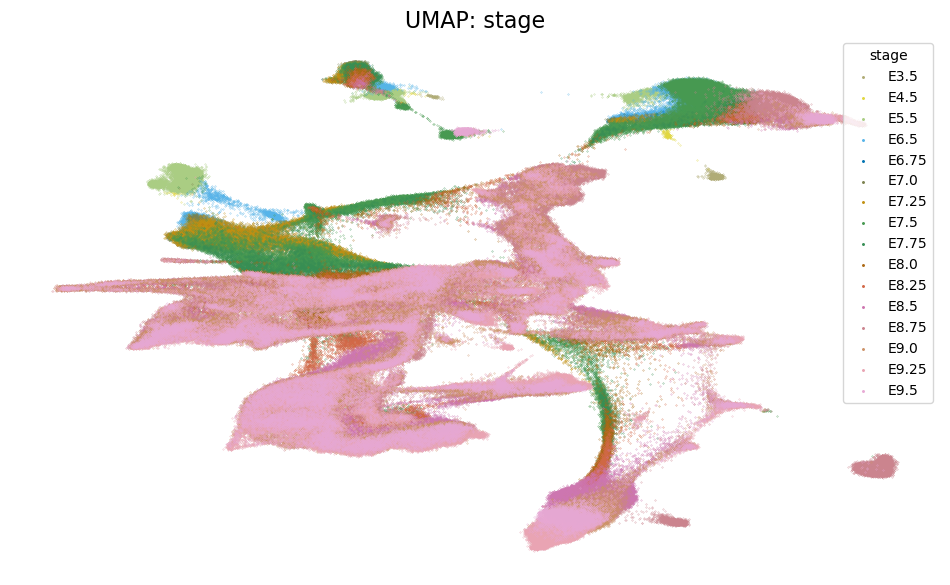

In [33]:

# Define UMAP coordinates
umap_coords = adata.obsm['X_umap_scVI']

# Define the batch variable
voi = 'stage'

# Extract value colors and symbols from adata.uns
colormap = adata.uns[f'colormap_{voi}']

# Set the point size
pointsize = 0.05

# Create a color-mapped and symbol-mapped scatter plot
fig, ax = plt.subplots(figsize=(12, 7))

# Iterate over valuees and plot each with corresponding color and marker
for value, color in colormap.items():
    mask = adata.obs[voi] == value
    ax.scatter(umap_coords[mask, 0], umap_coords[mask, 1], s=pointsize, c=color, label=value)

# Set plot legend and title
ax.legend(title=f'{voi}', loc='upper right', scatterpoints=1, markerscale=5)
ax.set_title(f'UMAP: {voi}', fontsize=16)
ax.axis('off')

# Show the plot
plt.show()


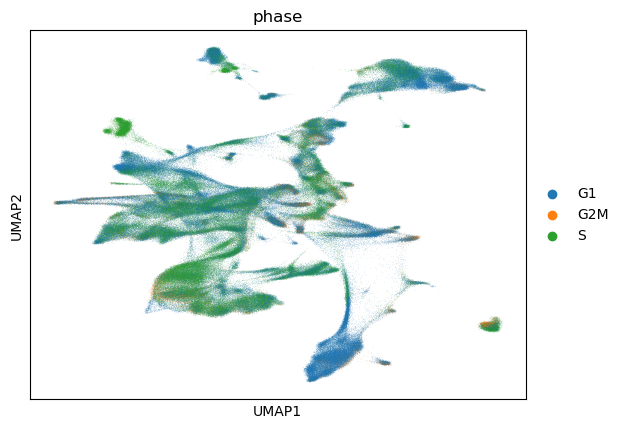

In [40]:
sc.pl.umap(adata, color = 'phase')

## INTERACTIVE PLOT

In [2]:
import plotly.io as pio
import re
import seaborn as sns
import matplotlib
import plotly.express as px
import plotly.graph_objects as go
import random


pio.renderers.keys() ## just to know which keys are available
pio.renderers.default = "iframe_connected" ## for interactive
#pio.renderers.default = "notebook" ## for hmtl

## setting dataset and title
data = adata
title = 'Atlas'

## reduction info
reduction_method = 'UMAP'
reduction = 'X_umap_scVI'

## variabel of interest and meta of interst
voi = 'stage'
meta_1 = 'batch'
meta_2 = 'annotation'
meta_3 = 'batch'
meta_4 = 'batch'

## set the colormap and other parameters
colormap = adata.uns[f'colormap_{voi}']
## or use a random color
random_color = lambda: f'#{random.randint(0, 0xFFFFFF):06x}'


# Set up plotting dataframe
umap_df = pd.DataFrame(data.obsm[reduction], columns=[f'{reduction_method}1', f'{reduction_method}2'])
for meta in [voi, meta_1, meta_2, meta_3, meta_4]:
    umap_df[meta] = data.obs[meta].values
    
# Sort umap_df alphanumerically
umap_df = umap_df.sort_values(by=voi, key=lambda col: col.str.lower())

# Initialize a new Figure
fig = go.Figure()

# Create the background trace with go.Scattergl for efficiency with large datasets
traces_back = go.Scattergl(
    x=umap_df[f'{reduction_method}1'],
    y=umap_df[f'{reduction_method}2'],
    mode='markers',
    marker=dict(
        color='gray',   # Set color to gray
        size=3,         # Smaller point size
        opacity=0.2     # Semi-transparent points
    ),
    showlegend=False,   # Hide legend for background trace
    hoverinfo='skip' )

## adding background trace
fig.add_trace(traces_back)

## define helper function for the hover text
def construct_hover_text(row, fields):
    return "<br>".join(f"{field}: {row[field]}" for field in fields)
    
# Create and add foreground traces for each unique value in 'voi'
for value in umap_df[voi].unique():
    # Filter data for the current unique value
    value_data = umap_df[umap_df[voi] == value]
    ## set the color value
    value_color = colormap[value]
    # Set the color to a random color
    #value_color = random_color()
    
    # Construct hover text for each point
    hover_text = value_data.apply(lambda row: construct_hover_text(row, [voi, meta_1, meta_2]), axis=1)
   
    # Create a trace for this value
    trace = go.Scattergl(
        x=value_data[f'{reduction_method}1'],
        y=value_data[f'{reduction_method}2'],
        mode='markers',
        marker=dict(
            size=5,
            color=value_color),
        name=str(value),  # Legend name for this category
        hoverinfo='text',
        hovertext=hover_text)
    
    # Add the trace to the figure
    fig.add_trace(trace)

## some layout paramters
fig.update_layout(
    title=f'{title}',
    xaxis_title=f'{reduction_method}1',
    yaxis_title=f'{reduction_method}1',
    legend_title=f'', 
    xaxis=dict(
            showgrid=False,
            showticklabels=False,), 
    yaxis=dict(
        showgrid=False, 
        showticklabels=False), 
    plot_bgcolor='white', 
    height = 800, 
    width = 1200
)
fig.show()

NameError: name 'adata' is not defined

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [34]:
import plotly.io as pio
import re
import seaborn as sns
import matplotlib
import plotly.express as px
import plotly.graph_objects as go
import random


pio.renderers.keys() ## just to know which keys are available
pio.renderers.default = "iframe_connected" ## for interactive
#pio.renderers.default = "notebook" ## for hmtl

## setting dataset and title
data = adata
title = 'Atlas'

## reduction info
reduction_method = 'UMAP'
reduction = 'X_umap_scVI'

## variabel of interest and meta of interst
voi = 'celltype_nowotschin'
meta_1 = 'batch'
meta_2 = 'stage'
meta_3 = 'batch'
meta_4 = 'batch'

## set the colormap and other parameters
colormap = adata.uns['colormap_annotation']
## or use a random color
random_color = lambda: f'#{random.randint(0, 0xFFFFFF):06x}'


# Set up plotting dataframe
umap_df = pd.DataFrame(data.obsm[reduction], columns=[f'{reduction_method}1', f'{reduction_method}2'])
for meta in [voi, meta_1, meta_2, meta_3, meta_4]:
    umap_df[meta] = data.obs[meta].values
    
# Sort umap_df alphanumerically
umap_df = umap_df.sort_values(by=voi, key=lambda col: col.str.lower())

# Initialize a new Figure
fig = go.Figure()

# Create the background trace with go.Scattergl for efficiency with large datasets
traces_back = go.Scattergl(
    x=umap_df[f'{reduction_method}1'],
    y=umap_df[f'{reduction_method}2'],
    mode='markers',
    marker=dict(
        color='gray',   # Set color to gray
        size=3,         # Smaller point size
        opacity=0.2     # Semi-transparent points
    ),
    showlegend=False,   # Hide legend for background trace
    hoverinfo='skip' )

## adding background trace
fig.add_trace(traces_back)

## define helper function for the hover text
def construct_hover_text(row, fields):
    return "<br>".join(f"{field}: {row[field]}" for field in fields)
    
# Create and add foreground traces for each unique value in 'voi'
for value in umap_df[voi].unique():
    # Filter data for the current unique value
    value_data = umap_df[umap_df[voi] == value]
    ## set the color value
    #value_color = colormap[value]
    # Set the color to a random color
    value_color = random_color()
    
    # Construct hover text for each point
    hover_text = value_data.apply(lambda row: construct_hover_text(row, [voi, meta_1, meta_2]), axis=1)
   
    # Create a trace for this value
    trace = go.Scattergl(
        x=value_data[f'{reduction_method}1'],
        y=value_data[f'{reduction_method}2'],
        mode='markers',
        marker=dict(
            size=5,
            color=value_color),
        name=str(value),  # Legend name for this category
        hoverinfo='text',
        hovertext=hover_text)
    
    # Add the trace to the figure
    fig.add_trace(trace)

## some layout paramters
fig.update_layout(
    title=f'{title}',
    xaxis_title=f'{reduction_method}1',
    yaxis_title=f'{reduction_method}1',
    legend_title=f'', 
    xaxis=dict(
            showgrid=False,
            showticklabels=False,), 
    yaxis=dict(
        showgrid=False, 
        showticklabels=False), 
    plot_bgcolor='white', 
    height = 800, 
    width = 1200
)
fig.show()

In [35]:
import plotly.io as pio
import re
import seaborn as sns
import matplotlib
import plotly.express as px
import plotly.graph_objects as go
import random


pio.renderers.keys() ## just to know which keys are available
pio.renderers.default = "iframe_connected" ## for interactive
#pio.renderers.default = "notebook" ## for hmtl

## setting dataset and title
data = adata
title = 'Atlas'

## reduction info
reduction_method = 'UMAP'
reduction = 'X_umap_scVI'

## variabel of interest and meta of interst
voi = 'annotation'
meta_1 = 'batch'
meta_2 = 'stage'
meta_3 = 'batch'
meta_4 = 'batch'

## set the colormap and other parameters
colormap = adata.uns[f'colormap_{voi}']
## or use a random color
random_color = lambda: f'#{random.randint(0, 0xFFFFFF):06x}'


# Set up plotting dataframe
umap_df = pd.DataFrame(data.obsm[reduction], columns=[f'{reduction_method}1', f'{reduction_method}2'])
for meta in [voi, meta_1, meta_2, meta_3, meta_4]:
    umap_df[meta] = data.obs[meta].values
    
# Sort umap_df alphanumerically
umap_df = umap_df.sort_values(by=voi, key=lambda col: col.str.lower())

# Initialize a new Figure
fig = go.Figure()

# Create the background trace with go.Scattergl for efficiency with large datasets
traces_back = go.Scattergl(
    x=umap_df[f'{reduction_method}1'],
    y=umap_df[f'{reduction_method}2'],
    mode='markers',
    marker=dict(
        color='gray',   # Set color to gray
        size=3,         # Smaller point size
        opacity=0.2     # Semi-transparent points
    ),
    showlegend=False,   # Hide legend for background trace
    hoverinfo='skip' )

## adding background trace
fig.add_trace(traces_back)

## define helper function for the hover text
def construct_hover_text(row, fields):
    return "<br>".join(f"{field}: {row[field]}" for field in fields)
    
# Create and add foreground traces for each unique value in 'voi'
for value in umap_df[voi].unique():
    # Filter data for the current unique value
    value_data = umap_df[umap_df[voi] == value]
    ## set the color value
    value_color = colormap[value]
    # Set the color to a random color
    #value_color = random_color()
    
    # Construct hover text for each point
    hover_text = value_data.apply(lambda row: construct_hover_text(row, [voi, meta_1, meta_2]), axis=1)
   
    # Create a trace for this value
    trace = go.Scattergl(
        x=value_data[f'{reduction_method}1'],
        y=value_data[f'{reduction_method}2'],
        mode='markers',
        marker=dict(
            size=5,
            color=value_color),
        name=str(value),  # Legend name for this category
        hoverinfo='text',
        hovertext=hover_text)
    
    # Add the trace to the figure
    fig.add_trace(trace)

## some layout paramters
fig.update_layout(
    title=f'{title}',
    xaxis_title=f'{reduction_method}1',
    yaxis_title=f'{reduction_method}1',
    legend_title=f'', 
    xaxis=dict(
            showgrid=False,
            showticklabels=False,), 
    yaxis=dict(
        showgrid=False, 
        showticklabels=False), 
    plot_bgcolor='white', 
    height = 800, 
    width = 1200
)
fig.show()

## Save data 

In [42]:
adata

AnnData object with n_obs × n_vars = 535935 × 8342
    obs: 'batch', 'stage', 'sample', 'covariate_composite', 'celltype_nowotschin', 'celltype_rosshandler', 'celltype_pijuansala', 'nowotschin_cluster', 'rosshandler_somite_count', 'rosshandler_anatomy', 'rosshandler_phase', 'rosshandler_S_score', 'rosshandler_G2M_score', 'rosshandler_louvain', 'rosshandler_leiden', 'annotation', 'mt-Atp6', 'mt-Atp8', 'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable'
    uns: 'colormap_annotation', 'colormap_batch', 'colormap_rosshandler', 'colormap_stage', 'log1p', 'symbolmap_batch', 'symbolmap_plotly_batch', 'symbolmap_plotly_stage', 'symbolmap_stage', 'colormap_condition', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors_scVI', 'umap'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_scVI', 'X_umap', 'X_umap_scVI'
    layers: 'log_normalized', 'raw_counts'
   

In [88]:
data_path = '/data/hadjantalab/lucas/atlas/data'

In [89]:
%%time
## saving the complete object, it ain't that big
file_path = os.path.join(data_path, "adata.h5ad")
adata.write_h5ad(file_path)

CPU times: user 12.3 s, sys: 16.5 s, total: 28.8 s
Wall time: 52.4 s


In [41]:
%%time
## saving the scVI model
file_path = os.path.join(data_path, "scvi/atlas")
model.save(file_path, overwrite = True)

CPU times: user 49 ms, sys: 11.9 ms, total: 60.9 ms
Wall time: 989 ms


In [42]:
# %%time
# ## saving everything seperately

# ## all metadata
# file_path = os.path.join(data_path, "adata_obs.csv")
# adata.obs.to_csv(file_path, index = 'cell')

# file_path = os.path.join(data_path, "adata_var.csv")
# adata.var.to_csv(file_path, index = 'mgi_symbol')

# file_path = os.path.join(data_path, "adata_uns.pickle")
# with open(file_path, 'wb') as handle:
#     pickle.dump(adata.uns, handle, protocol=pickle.HIGHEST_PROTOCOL)

# file_path = os.path.join(data_path, "adata_obsm.pickle")
# with open(file_path, 'wb') as handle:
#     pickle.dump(adata.obsm, handle, protocol=pickle.HIGHEST_PROTOCOL)

# file_path = os.path.join(data_path, "adata_obsp.pickle")
# with open(file_path, 'wb') as handle:
#     pickle.dump(adata.obsp, handle, protocol=pickle.HIGHEST_PROTOCOL)

# def save_sparse_csr(filename, array):
#     np.savez(filename, data=array.data, indices=array.indices, indptr=array.indptr, shape=array.shape)

# ## saving sparse matrix seperately
# file_path = os.path.join(data_path, "adata_X.npz")
# save_sparse_csr(file_path, adata.X)

## LOAD DATA

In [2]:
data_path = '/data/hadjantalab/lucas/atlas/data'

In [3]:
## saving the complete object, it ain't that big
file_path = os.path.join(data_path, "adata.h5ad")
adata = ad.read_h5ad(file_path)

## Empty gpu tensors

In [43]:
def get_gpu_tensors():
    gpu_tensors = []
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) and obj.is_cuda:
                gpu_tensors.append(obj)
        except:
            pass
    return gpu_tensors

# Example usage
gpu_tensors = get_gpu_tensors()
print(f"Found {len(gpu_tensors)} tensors on the GPU")
for i, tensor in enumerate(gpu_tensors):
    print(f"Tensor {i}: shape {tensor.shape}, dtype {tensor.dtype}")

Found 51 tensors on the GPU
Tensor 0: shape torch.Size([8342]), dtype torch.float32
Tensor 1: shape torch.Size([45, 256]), dtype torch.float32
Tensor 2: shape torch.Size([45]), dtype torch.float32
Tensor 3: shape torch.Size([45, 256]), dtype torch.float32
Tensor 4: shape torch.Size([45]), dtype torch.float32
Tensor 5: shape torch.Size([1, 256]), dtype torch.float32
Tensor 6: shape torch.Size([1]), dtype torch.float32
Tensor 7: shape torch.Size([1, 256]), dtype torch.float32
Tensor 8: shape torch.Size([1]), dtype torch.float32
Tensor 9: shape torch.Size([8342, 256]), dtype torch.float32
Tensor 10: shape torch.Size([8342]), dtype torch.float32
Tensor 11: shape torch.Size([8342, 256]), dtype torch.float32
Tensor 12: shape torch.Size([8342]), dtype torch.float32
Tensor 13: shape torch.Size([256, 8342]), dtype torch.float32
Tensor 14: shape torch.Size([256]), dtype torch.float32
Tensor 15: shape torch.Size([256]), dtype torch.float32
Tensor 16: shape torch.Size([256]), dtype torch.float32
T

/home/schroel1/miniconda3/envs/gpu2/lib/python3.10/site-packages/torch/__init__.py:836: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)


In [44]:
# Optionally clear GPU memory (if tensors are no longer needed)
for tensor in gpu_tensors:
    del tensor
torch.cuda.empty_cache()
## del does not immediately free up memory, bur removes references from object.
# if reference count of object drops to zero it becomes elligible for garabge collection
## I can then collect all the objects eligible with gc.collect() and free up vram and ram
gc.collect()

10733